# **Environment: Tank Water Level Control**

In [1]:
# Building the custom environment for OpenAi Gym

from gym import Env 
# Env is a placeholder class that allows us to build our environment

from gym.spaces import Box
# Superclass that is used to define observation and action spaces
#`Box` is for continuing-space, `Discrete` for discrete-space and `Dict` for multiple input
# https://github.com/openai/gym/blob/master/gym/spaces/box.py
"""Implementation of a space that represents closed boxes in euclidean space."""
"""
class Box(Space[np.ndarray]):
    A (possibly unbounded) box in :math:`\mathbb{R}^n`.
    Specifically, a Box represents the Cartesian product of n closed intervals.
    Each interval has the form of one of :math:`[a, b]`, :math:`(-\infty, b]`,
    :math:`[a, \infty)`, or :math:`(-\infty, \infty)`.
    There are two common use cases:
    * Identical bound for each dimension::
        >>> Box(low=-1.0, high=2.0, shape=(3, 4), dtype=np.float32)
        Box(3, 4)
    * Independent bound for each dimension::
        >>> Box(low=np.array([-1.0, -2.0]), high=np.array([2.0, 4.0]), dtype=np.float32)
        Box(2,)
    
"""
import numpy as np
import random

# (This removes np.float32 warnings, but can be solved too with np.float64 at "box" definition):
# gym.logger.set_level(40) 

class Model(Env):
# By passing Env to the class Model we defined, we inherit the methods and properties of OpenAI Gym

    def __init__(self):

        # Actions we can take, we only have the valve opening at each timestep (we consider a lower/upper bound of |1.0e-3|)
        self.action_space = Box(low=np.array([-1.0e-3]), high=np.array([1.0e-3]), dtype=np.float64)
        # The function "Box" can support a tensor

        # # Valve opening observation array (maximum physically possible opening of 1.0)
        # self.valve_opening  = Box(low=np.array([0.00]), high=np.array([1.00]), dtype=np.float64)

        # # Water Height observation array (assuming Maximum Height of Tank of 1.0 m)
        # self.water_height = Box(low=np.array([0.00]), high=np.array([1.00]), dtype=np.float64)

        # Inflow observation array (assuming Maximum Possible Flow of 150 m³/h) / remember: Inflow is not a state!
        # self.inflow = Box(low=np.array([0.00]), high=np.array([150.00]), dtype=np.float64)

        # Observation space array (only Valve opening and Water Height; both with lower bound 0.0 and upper bound 1.0)
        self.observation_space = Box(low=0.0, high=1.0, shape=(1, 2), dtype=np.float64)

        # Set observation space (reminder: flow isn't measured/ isn't a state)
        # self.observation_space = (self.inflow , self.valve_opening, self.water_height)

        ## Area of 3 m²
        ## Diameter of 1.95441 m
        self.tank_diameter = 1.95441

        # Set initial states (we can instantiate them a bit randomly - 10% var):
        # self.current_inflow = 100 + random.uniform(-10.00, 10.00)
        # self.current_valve_opening = 0.5 + random.uniform(-0.05, 0.05)
        # self.current_water_height = 0.5 + random.uniform(-0.05, 0.05)

        self.current_inflow = 100
        self.current_valve_opening = 0.5
        self.current_water_height = 0.5

        ##  Calculate Volume of Water inside Tank
        ##  Maximum Possible Volume of 3.0 m³
        self.current_water_volume = (((self.tank_diameter / 2) ** 2) * np.pi) * self.current_water_height

        ## Valve coefficient (Cv) is given
        self.valve_coefficient = 282.84

        ## Setpoint in terms of the Usual Operation Height of 0.5 m 
        self.setpoint =  0.5

        # Tolerance acceptable for setpoint error (in reward definition):
        self.tolerance = 1e-4 # test 1e-6
       
        self.state = (self.current_valve_opening, self.current_water_height)

        # Set episode length
        ## Timestep = 0.01h
        ## Episode total time = 2h (200 timesteps)
        ## Total number of episodes = 2000
        self.time_per_episode = 200

        # Initialize time counter
        self.time_step = 0

        # Initialize reward
        # self.reward = 0

    ## Provides current water height from the most up to date water volume
    def update_water_height(self):
        return self.current_water_volume / (((self.tank_diameter / 2) ** 2) * np.pi)   
   
    ## Calculates the non-linear outflow rate of water from the tank
    def outflow(self):
        return self.valve_coefficient * self.current_valve_opening * np.sqrt(abs(self.update_water_height())) 

    ## Error of water height from current set point
    def error(self):
        error=(self.update_water_height() - self.setpoint)
        return error
        
    def step(self, action):

        # Flow rate of water + disturbances
        self.current_inflow = self.current_inflow + self.disturbance(self.time_step)

        ## Current water volume in the tank
        self.current_water_volume = self.current_water_volume + self.current_inflow - self.outflow()

        ## Water volume can only be at 0 or maximum volume limit
        self.current_water_volume = np.clip(self.current_water_volume, 0, 3.0)

        ## Update current water height
        self.current_water_height = self.update_water_height()

        ## Water height can only be at 0 or maximum tank height limit
        self.current_water_height = np.clip(self.current_water_height, 0, 1.0)

        # Apply action (valve opening)
        # Continuous: [-0.01, 0.01] at each timestep
        self.current_valve_opening =  self.current_valve_opening + action

        ## Valve opening can only be at 0 or maximum overture limit
        self.current_valve_opening = np.clip(self.current_valve_opening, 0, 1.0)

        # Add 1 Timestep = 0.01h
        self.time_step += 1
        
        # Calculate reward
        ## Reward: minus the square of height error -(m)^2
        ## Our objective is to minimize this error (or negative reward)
        # reward = -((self.error())**2)

        if (self.error())**2 <= self.tolerance : 
            reward = 1 
        else: 
            reward = -1 

        ## Determine whether it is a terminal state
        terminal = self.is_terminal(self.current_water_height)

        # Set placeholder for info
        info = {}

        # Return step information
        return self.retrieve_observation(), reward, terminal, info

    ## The terminal state is reached if time step reaches more than 200 or if water level exceeds the 2 extremes
    def is_terminal(self, water_h):
        if self.time_step >= self.time_per_episode-1 or self.current_water_height == 0 or self.current_water_height == 1:
            return True
        else:
            return False

    ## Disturbances on flow rate:
    def disturbance(self, time):
        if self.time_step == 10: #0.1 h
            return 20
        elif self.time_step == 100: #1.1 h
            return -20
        else:
            return 0

    ## Retrieve current state
    def retrieve_observation(self):

        self.state = (
            self.current_valve_opening, self.current_water_height
        )
        return self.state

    def render(self):
        # Implement visualization for a game environment for example
        pass
    
    ## Reset the current state of the water tank. This involves time_step, water volume, input flow rate of water and error
    def reset(self):

        ## Set point remains fixed:
        self.setpoint = 0.5

        ## Reset time counter and other variables (we can instantiate them as before, a bit randomly)
        self.time_step = 0
        # self.current_inflow = 100 + random.uniform(-10.00, 10.00)
        # self.current_valve_opening = 0.5 + random.uniform(-0.05, 0.05)
        # self.current_water_height = 0.5 + random.uniform(-0.05, 0.05)

        self.current_inflow = 100
        self.current_valve_opening = 0.5
        self.current_water_height = 0.5

        return self.retrieve_observation()

## **Sarsa $(\lambda)$ with Gaussian RBF for Function $[Q(s,a)]$ Approximation**

In [2]:
# SARSA-lambda with Gaussian radial basis functions for action-value approximation

import gym
import numpy as np
import matplotlib.pyplot as plt

# Initializations
env = Model()
states = env.observation_space.shape

# actions = env.action_space.n  # this is for discrete action space
num_actions = env.action_space.shape
num_actions_int  = sum(num_actions)  # transforming tuple on integer
dim = env.observation_space.high.size

num_actions = 3

# Parameters
# eps = 0.1, Lambda = 0.5, alpha = 0.008, gamma = 0.99
num_rbf = 4 * np.ones(num_actions).astype(int)
width = 1. / (num_rbf - 1.)
rbf_sigma = width[0] / 2.
epsilon = 0.1
epsilon_final = 0.1
Lambda = 0.5
alpha = 0.01
gamma = 0.99
#num_episodes = 2000
num_episodes = 20
num_timesteps = 200

xbar = np.zeros((2, dim))
xbar[0, :] = env.observation_space.low
xbar[1, :] = env.observation_space.high
num_ind = np.prod(num_rbf)
activations = np.zeros(num_ind)
new_activations = np.zeros(num_ind)
theta = np.zeros((num_ind, num_actions))
rbf_den = 2 * rbf_sigma ** 2
epsilon_coefficient = (epsilon - epsilon_final) ** (1. / num_episodes)
ep_length = np.zeros(num_episodes)
np.set_printoptions(precision=2)

# Construct ndarray of rbf centers
c = np.zeros((num_ind, dim))
for i in range(num_rbf[0]):
    for j in range(num_rbf[1]):
        c[i*num_rbf[1] + j, :] = (i * width[1], j * width[0])


# Returns the state scaled between 0 and 1
# def normalize_state(_s):
#     _y = np.zeros(len(_s))
#     for _i in range(len(_s)):
#         _y[_i] = (_s[_i] - xbar[0, _i]) / (xbar[1, _i] - xbar[0, _i])
#     return _y

# Returns an ndarray of radial basis function activations
def phi(_state):
    _phi = np.zeros(num_ind)
    for _k in range(num_ind):
        _phi[_k] = np.exp(-np.linalg.norm(_state - c[_k, :]) ** 2 / rbf_den)
    return _phi

# Returns an action following an epsilon-greedy policy
def epsilon_greedy(_epsilon, _vals):
    _rand = np.random.random()
    if _rand < 1. - _epsilon:
        _action = _vals.argmax()
    else:
        _action = env.action_space.sample()
    return int(_action)

# Returns the value of each action at some state
def action_values(_activations, _theta):
    _val = np.dot(_theta.T, _activations)
    return _val

# Returns the value of an action at some state
def action_value(_activations, _action, _theta):
    _val = np.dot(_theta[:, _action], _activations)
    return _val

Episode:0 Score:0
Episode:0 Water Height:[0.0]
Episode:0 Setpoint:[0.5]
Episode:0 Water Volume:[0.0]
Episode:0 Valve Opening:[0.5]
Episode:0 Inflow:[100]
Episode:0 Outflow:[0.0]
Episode:1 Score:0
Episode:1 Water Height:[1.0]
Episode:1 Setpoint:[0.5]
Episode:1 Water Volume:[3.0]
Episode:1 Valve Opening:[1.0]
Episode:1 Inflow:[100]
Episode:1 Outflow:[282.8400068903083]
Episode:2 Score:0
Episode:2 Water Height:[0.0]
Episode:2 Setpoint:[0.5]
Episode:2 Water Volume:[0.0]
Episode:2 Valve Opening:[1.0]
Episode:2 Inflow:[100]
Episode:2 Outflow:[0.0]
Episode:3 Score:0
Episode:3 Water Height:[1.0]
Episode:3 Setpoint:[0.5]
Episode:3 Water Volume:[3.0]
Episode:3 Valve Opening:[1.0]
Episode:3 Inflow:[100]
Episode:3 Outflow:[282.8400068903083]
Episode:4 Score:0
Episode:4 Water Height:[0.0]
Episode:4 Setpoint:[0.5]
Episode:4 Water Volume:[0.0]
Episode:4 Valve Opening:[1.0]
Episode:4 Inflow:[100]
Episode:4 Outflow:[0.0]
Episode:5 Score:0
Episode:5 Water Height:[1.0]
Episode:5 Setpoint:[0.5]
Episode:5 

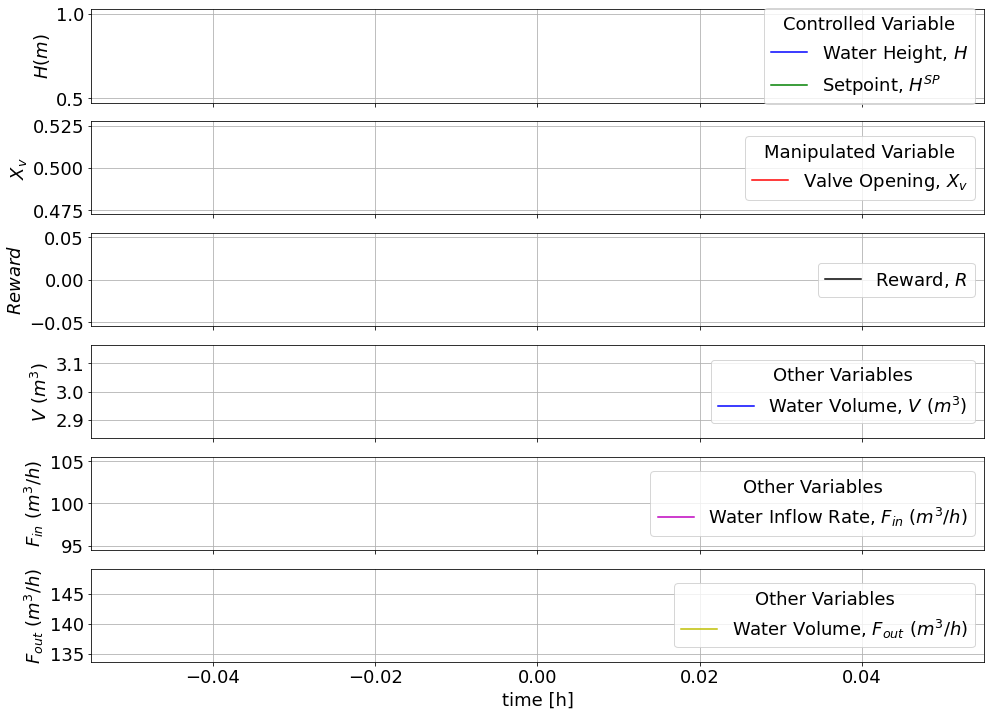

In [3]:
# SARSA lambda loop

from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18

for ep in range(num_episodes):

    e = np.zeros((num_ind, num_actions))
    state = env.reset()
    activations = phi(state)
    # print "activations = ", np.reshape(activations.ravel(order='F'), (num_rows, num_cols))
    vals = action_values(activations, theta)
    action = epsilon_greedy(epsilon, vals)

    #Store lists for plot
    # error_list = []
    ep_reward_list=[]
    water_height_list = []
    valve_opening_list = []
    setpoint_list = []
    water_volume_list = []
    inflow_list = []
    outflow_list = []
    score = 0

    # Each episode
    for t in range(num_timesteps):

        # env.render()
        new_state, reward, done, info = env.step(action)
        # new_state = normalize_state(new_state)
        new_activations = phi(new_state)
        new_vals = action_values(new_activations, theta)
        new_action = epsilon_greedy(epsilon, new_vals)
        Q = action_value(activations, action, theta)
        Q_new = action_value(new_activations, new_action, theta)

        if done:
            target = reward - Q
        else:
            target = reward + gamma * Q_new - Q
        # e[:, action] += activations  # accumulating traces
        e[:, action] = activations  # replacing traces

        for k in range(num_ind):
            for a in range(num_actions):
                theta[k, a] += alpha * target * e[k, a]
        e *= gamma * Lambda

        if t % 1 != 0:
            # print "t = ", t
            # print "new_state = ", new_state
            # print "new_activations = ", np.reshape(new_activations.ravel(order='F'), (num_rows, num_cols))
            # print "new_vals", new_vals
            # print "Q = ", Q
            # print "Q_new = ", Q_new
            # print "action = ", action
            # print "target = ", target
            # print "e =", e
            # print "theta = \n", np.reshape(theta.ravel(order='F'), (num_actions, num_rows, num_cols))
            # print "---------------------------------------------------------------------------"

          state = new_state.copy()
          activations = new_activations.copy()
          action = new_action

          score+=reward



        if done:
            break

    ep_length[ep] = t
    # print "t = ", t
    epsilon *= epsilon_coefficient

    ## Record error

    # error_list.append(-abs(env.current_water_height- env.setpoint))

    ## Record reward

    ep_reward_list.append(score)

    ## Record information of state

    water_height_list.append(env.current_water_height)
    valve_opening_list.append(env.current_valve_opening)

    ## Record setpoint (actually it's constant)

    setpoint_list.append(env.setpoint)

    ## Record other variables

    water_volume_list.append(env.current_water_volume)
    inflow_list.append(env.current_inflow)
    outflow_list.append(env.outflow())

    # Episode_average_reward = sum(error_list)/len(error_list)
    # ep_reward_list.append(Episode_average_reward)

    print('Episode:{} Score:{}'.format(ep, score))
    print('Episode:{} Water Height:{}'.format(ep, water_height_list))
    print('Episode:{} Setpoint:{}'.format(ep, setpoint_list))
    print('Episode:{} Water Volume:{}'.format(ep, water_volume_list))
    print('Episode:{} Valve Opening:{}'.format(ep, valve_opening_list))
    print('Episode:{} Inflow:{}'.format(ep, inflow_list))
    print('Episode:{} Outflow:{}'.format(ep, outflow_list))

    # if (ep%num_episodes-1)==0:
fig, ax = plt.subplots(6, 1, sharex=True, figsize=(16,12))
ax[0].plot(water_height_list, label="water height",color="b")
ax[0].plot(setpoint_list, label="setpoint",color="g")
ax[1].plot(valve_opening_list,label="valve opening",color="r")
ax[2].plot(ep_reward_list, label="reward", color="k")
ax[3].plot(water_volume_list, label="water volume",color="b")
ax[4].plot(inflow_list, label="inflow",color="m")
ax[5].plot(outflow_list, label="outflow",color="y")

ax[0].set_ylabel('$H(m)$')
# ax[0].set_xlabel('time [h]')
ax[1].set_ylabel('$X_{v}$')
# ax[1].set_xlabel('time [h]')
ax[2].set_ylabel('$Reward$')
# ax[2].set_xlabel('time [h]')
ax[3].set_ylabel('$V \ (m^{3})$')
# ax[3].set_xlabel('time [h]')
ax[4].set_ylabel('$F_{in} \ (m^{3}/h)$')
# ax[4].set_xlabel('time [h]')
ax[5].set_ylabel('$F_{out} \ (m^{3}/h)$')
ax[5].set_xlabel('time [h]')

ax[0].legend(['Water Height, $H$', 'Setpoint, $H^{SP}$'], title='Controlled Variable', loc='center right')
ax[1].legend(['Valve Opening, $X_{v}$'], title='Manipulated Variable', loc='center right')
ax[2].legend(['Reward, $R$'], loc='center right')
ax[3].legend(['Water Volume, $V \ (m^{3})$'], title='Other Variables', loc='center right')
ax[4].legend(['Water Inflow Rate, $F_{in} \ (m^{3}/h)$'], title='Other Variables', loc='center right')
ax[5].legend(['Water Volume, $F_{out} \ (m^{3}/h)$'], title='Other Variables', loc='center right')

plt.show()